In [1]:

# Connect Driver
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# CSV_HEADER: Danh sách các cột mà bạn muốn giữ lại
CSV_HEADER = [
    "dur", "proto", "service", "state", "spkts", "dpkts", "sbytes", "dbytes", "rate", "sttl", "dttl",
    "sload", "dload", "sloss", "dloss", "sinpkt", "dinpkt", "sjit", "djit", "swin", "stcpb", "dtcpb",
    "dwin", "tcprtt", "synack", "ackdat", "smean", "dmean", "trans_depth", "response_body_len",
    "ct_srv_src", "ct_state_ttl", "ct_dst_ltm", "ct_src_dport_ltm", "ct_dst_sport_ltm",
    "ct_dst_src_ltm", "is_ftp_login", "ct_ftp_cmd", "ct_flw_http_mthd", "ct_src_ltm",
    "ct_srv_dst", "is_sm_ips_ports", "label"
]

# Đọc dữ liệu từ các file CSV
train_data = pd.read_csv("/content/drive/MyDrive/BT3/UNSW_NB15_testing-set.csv", usecols=CSV_HEADER)
test_data = pd.read_csv("/content/drive/MyDrive/BT3/UNSW_NB15_testing-set.csv", usecols=CSV_HEADER)

# Chuyển các cột dạng categorical thành one-hot encoding
categorical_columns = ['proto', 'service', 'state']  # Chỉ mã hóa các cột categorical (không bao gồm 'label')
for col in categorical_columns:
    train_data[col] = train_data[col].astype('category')
    test_data[col] = test_data[col].astype('category')

# Sử dụng one-hot encoding cho các cột categorical
train_data = pd.get_dummies(train_data, columns=categorical_columns)
test_data = pd.get_dummies(test_data, columns=categorical_columns)

# Đảm bảo bộ dữ liệu kiểm tra có các cột giống như bộ dữ liệu huấn luyện
test_data = test_data.reindex(columns=train_data.columns, fill_value=0)

# Mã hóa nhãn thành số (Label Encoding) trước khi one-hot encoding
label_encoder = LabelEncoder()
train_data['label'] = label_encoder.fit_transform(train_data['label'])
test_data['label'] = label_encoder.transform(test_data['label'])

# Tách các tính năng (features) và nhãn (labels)
X_train = train_data.drop(columns=['label'])  # Loại bỏ cột nhãn
y_train = train_data['label']
X_test = test_data.drop(columns=['label'])
y_test = test_data['label']

# Tiền xử lý dữ liệu (Điền giá trị thiếu, chuẩn hóa, v.v...)
X_train = X_train.fillna(X_train.mean())  # Điền giá trị thiếu bằng giá trị trung bình
X_test = X_test.fillna(X_test.mean())

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

Accuracy of the global model after FedAvg: 0.8187339066219695


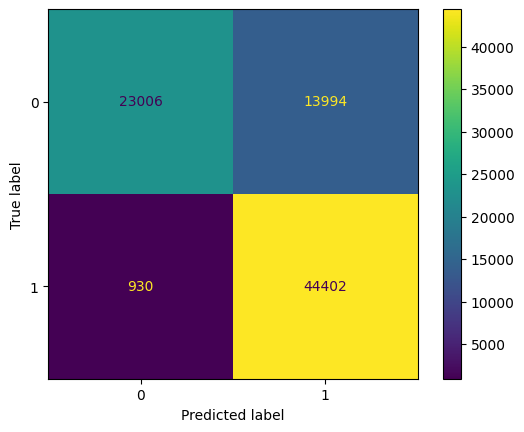

In [ ]:
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Giả sử chia dữ liệu cho các client
num_clients = 3  # Giả sử có 3 client
X_train_split = np.array_split(X_train, num_clients)
y_train_split = np.array_split(y_train, num_clients)

# Huấn luyện mô hình cho mỗi client
client_models = []
client_weights = []
for i in range(num_clients):
    model = MLPClassifier(hidden_layer_sizes=(32, 16), max_iter=50, random_state=42)
    model.fit(X_train_split[i], y_train_split[i])
    client_models.append(model)
    client_weights.append(model.coefs_)  # Lưu trọng số của mô hình

# Thu thập kích thước dữ liệu từ các client
client_data_sizes = [len(y) for y in y_train_split]

# Hàm tổng hợp trọng số (FedAvg)
def weighted_federated_averaging(client_weights, client_data_sizes):
    """
    Thực hiện FedAvg để tổng hợp trọng số mô hình.
    """
    total_data = sum(client_data_sizes)
    # Trung bình trọng số
    aggregated_weights = []
    for weights in zip(*client_weights):  # Lặp qua từng lớp trọng số
        aggregated_weights.append(
            sum((data_size / total_data) * layer for layer, data_size in zip(weights, client_data_sizes))
        )
    return aggregated_weights
import numpy as np

#median_federated_averaging
def median_federated_averaging(client_weights):
    aggregated_weights = []
    for weights in zip(*client_weights):
        weight_array = np.array(weights)  
        median_weights = np.median(weight_array, axis=0)
        aggregated_weights.append(median_weights)
    return aggregated_weights

# Thực hiện FedAvg để tạo mô hình toàn cục
global_weights = weighted_federated_averaging(client_weights, client_data_sizes)

# Khởi tạo một mô hình toàn cục
global_model = MLPClassifier(hidden_layer_sizes=(32, 16), max_iter=1, random_state=42, warm_start=True)
global_model.fit(X_train, y_train)  # Cần chạy một lần để khởi tạo các lớp mô hình
global_model.coefs_ = global_weights  # Cập nhật trọng số với kết quả từ FedAvg

# Đánh giá mô hình toàn cục trên tập kiểm tra
y_pred = global_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of the global model after FedAvg:", accuracy)

# Hiển thị ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()
